# Feature‑Count Experiment  
This notebook measures how classification accuracy varies as we include increasing numbers of top‑ranked features.  

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# adjust path if needed
df_feat = pd.read_pickle('df_feat.pkl')

target_col = 'mood_cat'
exclude_cols = ['nextday', 'mood_cat']
feature_cols = [c for c in df_feat.columns if c not in exclude_cols]

In [32]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_feat[feature_cols], df_feat[target_col])
importances = rf.feature_importances_

# sort descending
sorted_features = [
    f for _, f in sorted(zip(importances, feature_cols), reverse=True)
]

In [33]:

# 1) Encode target exactly as you did before
le = LabelEncoder()
df_feat['y_enc'] = le.fit_transform(df_feat[target_col])

# 2) Scale all features
scaler = StandardScaler()
df_feat[feature_cols] = scaler.fit_transform(df_feat[feature_cols])

In [34]:
results = []
# try 2, 4, 6, … up to all features
feature_counts = list(range(2, len(sorted_features)+1, 2))

for n in feature_counts:
    sel = sorted_features[:n]
    X = df_feat[sel]
    y = df_feat[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({'num_features': n, 'accuracy': acc})

results_df = pd.DataFrame(results)
results_df.head()

,num_features,accuracy
0,2,0.379310
1,4,0.420690
2,6,0.455172
3,8,0.462069
4,10,0.468966


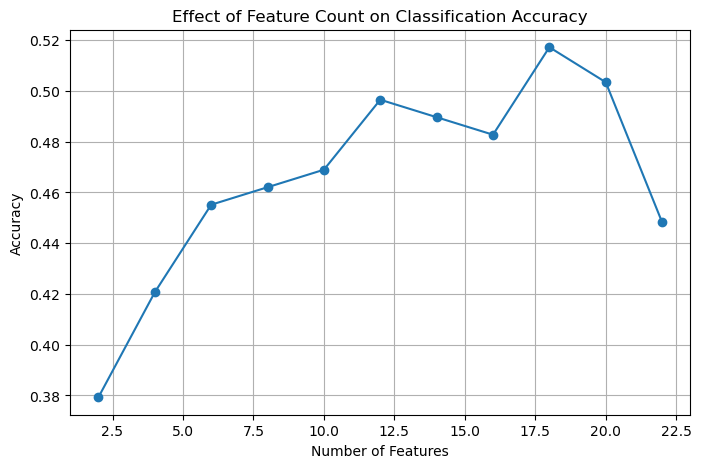

In [35]:
plt.figure(figsize=(8,5))
plt.plot(results_df['num_features'], results_df['accuracy'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Effect of Feature Count on Classification Accuracy')
plt.grid(True)
plt.show()

In [36]:
# (after loading df_feat & excluding target)
engineered = [c for c in feature_cols if 'log' in c or 'ratio' in c]
raw        = [c for c in feature_cols if c not in engineered]

feature_sets = {
    'All features':    feature_cols,
    'Raw features':    raw,
    'Engineered only': engineered
}

print({k: len(v) for k,v in feature_sets.items()})
# e.g. {'All features': 23, 'Raw features': 20, 'Engineered only': 3}

{'All features': 22, 'Raw features': 19, 'Engineered only': 3}


In [37]:
results = []

for name, feats in feature_sets.items():
    # get importances within this subset
    rf0 = RandomForestClassifier(n_estimators=100, random_state=42)
    rf0.fit(df_feat[feats], df_feat[target_col])
    imp = pd.Series(rf0.feature_importances_, index=feats) \
            .sort_values(ascending=False)

    # vary from 2 → len(feats) by step=2
    for n in range(2, len(feats)+1, 2):
        sel = imp.index[:n].tolist()
        X = df_feat[sel]; y = df_feat[target_col]
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        m = RandomForestClassifier(n_estimators=100, random_state=42)
        m.fit(X_tr, y_tr)
        acc = accuracy_score(y_te, m.predict(X_te))
        results.append({
            'Feature set': name,
            'n_features': n,
            'Accuracy':   acc
        })

res = pd.DataFrame(results)
res.head()

,Feature set,n_features,Accuracy
0,All features,2,0.379310
1,All features,4,0.420690
2,All features,6,0.455172
3,All features,8,0.462069
4,All features,10,0.468966


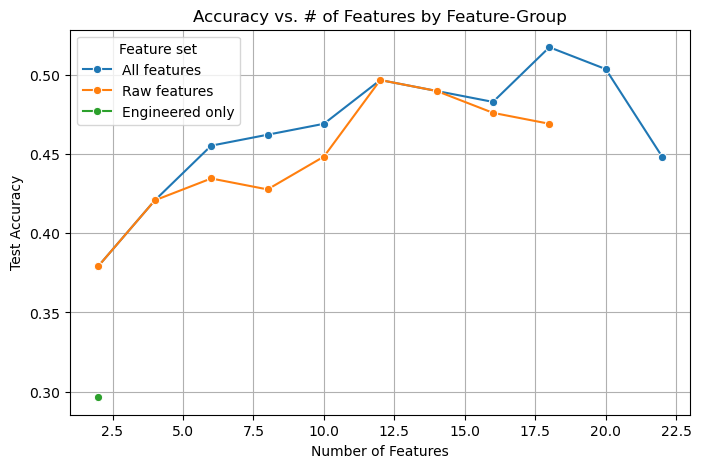

In [38]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.lineplot(
    data=res,
    x='n_features',
    y='Accuracy',
    hue='Feature set',
    marker='o'
)
plt.title('Accuracy vs. # of Features by Feature‐Group')
plt.xlabel('Number of Features')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

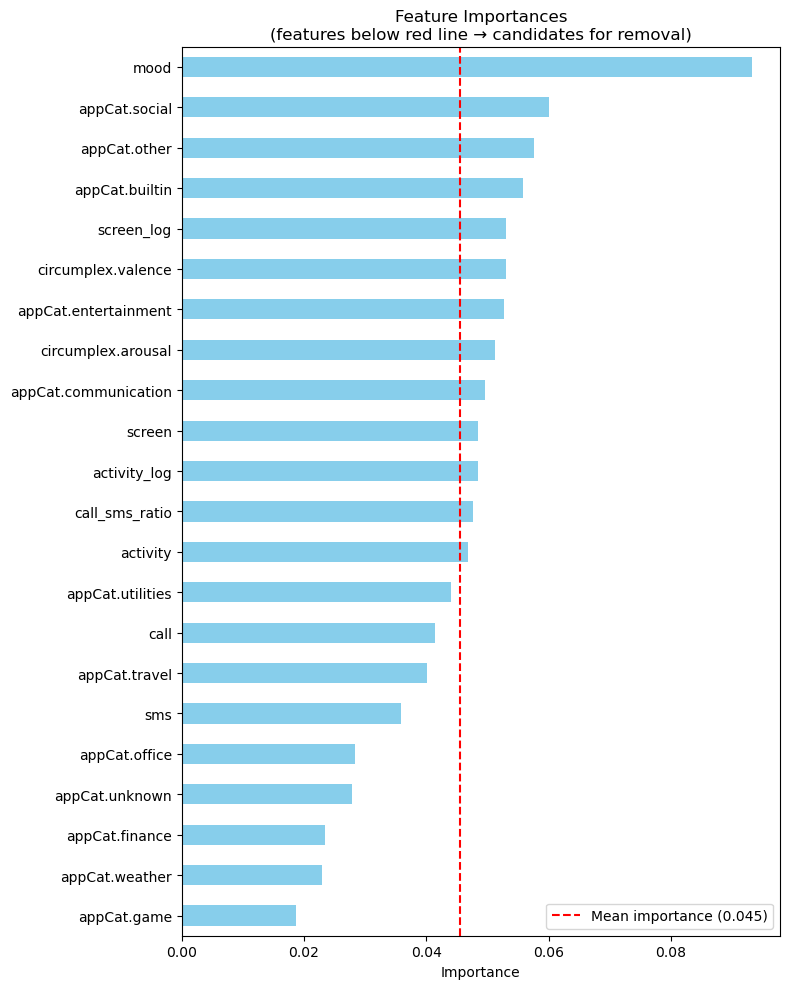

Suggested for removal: ['appCat.game', 'appCat.weather', 'appCat.finance', 'appCat.unknown', 'appCat.office', 'sms', 'appCat.travel', 'call', 'appCat.utilities']


In [39]:
# 1) compute & sort importances
imp = pd.Series(rf.feature_importances_, index=feature_cols)
imp = imp.sort_values()

# 2) plot horizontal bar chart
plt.figure(figsize=(8,10))
imp.plot(kind='barh', color='skyblue')
plt.axvline(imp.mean(), color='red', linestyle='--', 
            label=f"Mean importance ({imp.mean():.3f})")
plt.title("Feature Importances\n(features below red line → candidates for removal)")
plt.xlabel("Importance")
plt.legend()
plt.tight_layout()
plt.show()

# 3) list low‐importance features
to_drop = imp[imp < imp.mean()].index.tolist()
print("Suggested for removal:", to_drop)

Baseline (22 feats): 0.483
Pruned   (13 feats): 0.448


<Figure size 600x400 with 0 Axes>

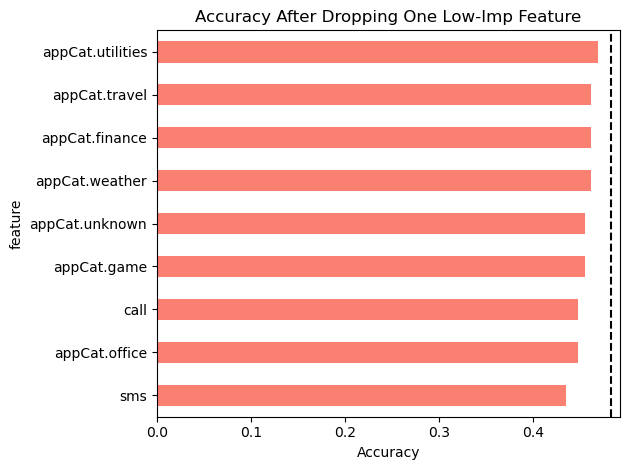


Lowest‐impact removals:
          feature  accuracy
5             sms  0.434483
4   appCat.office  0.448276
7            call  0.448276
0     appCat.game  0.455172
3  appCat.unknown  0.455172


In [40]:
# the low‐importance list you found
low_imp = [
    'appCat.game', 'appCat.weather', 'appCat.finance',
    'appCat.unknown', 'appCat.office', 'sms',
    'appCat.travel', 'call', 'appCat.utilities'
]

def eval_feats(feats):
    X = df_feat[feats]
    y = df_feat['y_enc']                # use the encoded target
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y                       # preserve class‑balance
    )
    m = RandomForestClassifier(n_estimators=100, random_state=42)
    m.fit(X_tr, y_tr)
    return accuracy_score(y_te, m.predict(X_te))

# 1) baseline with all features
baseline_acc = eval_feats(feature_cols)
# 2) drop all low‐imp features
pruned_feats = [f for f in feature_cols if f not in low_imp]
pruned_acc   = eval_feats(pruned_feats)

print(f"Baseline ({len(feature_cols)} feats): {baseline_acc:.3f}")
print(f"Pruned   ({len(pruned_feats)} feats): {pruned_acc:.3f}")

# 3) individual feature removal
indiv = []
for f in low_imp:
    feats = [c for c in feature_cols if c!=f]
    indiv.append((f, eval_feats(feats)))

indiv_df = pd.DataFrame(indiv, columns=['feature','accuracy']) \
               .sort_values('accuracy', ascending=True)

# 4) plot
plt.figure(figsize=(6,4))
indiv_df.plot(
    x='feature', y='accuracy', kind='barh',
    legend=False, color='salmon'
)
plt.axvline(baseline_acc, color='k', linestyle='--', label='all feats')
plt.title("Accuracy After Dropping One Low‑Imp Feature")
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()

print("\nLowest‐impact removals:")
print(indiv_df.head())

c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


HMM baseline (22 feats): 0.186
HMM pruned   (13 feats): 0.214


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

<Figure size 600x400 with 0 Axes>

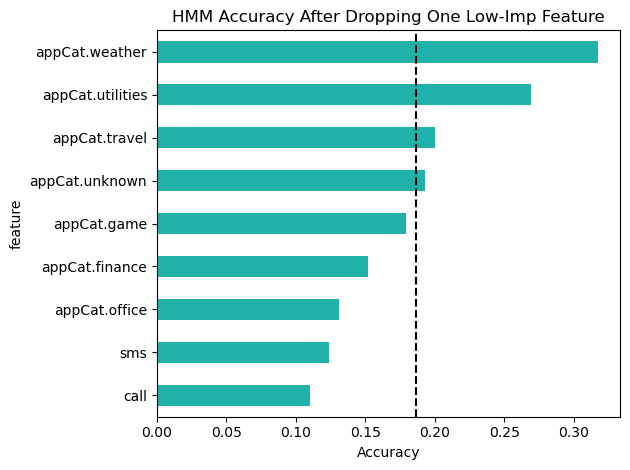


Worst HMM removals:
          feature  accuracy
7            call  0.110345
5             sms  0.124138
4   appCat.office  0.131034
2  appCat.finance  0.151724
0     appCat.game  0.179310


In [41]:
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import accuracy_score

def eval_hmm(feats):
    X = df_feat[feats]
    y = df_feat['y_enc']                # use the encoded target
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y                       # preserve class‑balance
    )
    # n_components = number of mood bins
    model = GaussianHMM(n_components=len(np.unique(y)),
                        covariance_type='diag',
                        n_iter=100,
                        random_state=42)
    model.fit(X_tr)
    y_pred = model.predict(X_te)
    return accuracy_score(y_te, y_pred)

# 1) baseline vs. dropping all low‐imp features
baseline_hmm = eval_hmm(feature_cols)
pruned_hmm   = eval_hmm(pruned_feats)
print(f"HMM baseline ({len(feature_cols)} feats): {baseline_hmm:.3f}")
print(f"HMM pruned   ({len(pruned_feats)} feats): {pruned_hmm:.3f}")

# 2) individual ablations
indiv_hmm = []
for f in low_imp:
    feats = [c for c in feature_cols if c!=f]
    indiv_hmm.append((f, eval_hmm(feats)))

indiv_hmm_df = (
    pd.DataFrame(indiv_hmm, columns=['feature','accuracy'])
      .sort_values('accuracy', ascending=True)
)

# 3) plot
plt.figure(figsize=(6,4))
indiv_hmm_df.plot(
    x='feature', y='accuracy', kind='barh',
    legend=False, color='lightseagreen'
)
plt.axvline(baseline_hmm, color='k', linestyle='--', label='all feats')
plt.title("HMM Accuracy After Dropping One Low‑Imp Feature")
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()

print("\nWorst HMM removals:")
print(indiv_hmm_df.head())